## 单表代换辅助工具

# 题目要求：
1.完成单表代换的加密和解密过程

2.辅助破译单表代换密文，本题目采用唯密文攻击
* 根据一般英文的频率统计分布规律给出初始化的静态建议
* 根据上下文的语境语法分析给出交互式的动态建议，并保证建议的泛化性与准确性
* 本程序旨在帮助初学者进一步深入了解古典密码学中的单表代换破译的知识，故使用该程序者根据静态建议和动态建议不断更新明文密文对的字母映射关系，从宏观角度分析破译过程中明文的特征，反复迭代直至完成破译


In [49]:
from collections import Counter
import re


为方便起见，我们采用经典的凯撒密码加密，进一步增加破译的复杂度，我们程序建议密钥长度需跟明文长度相同。

In [50]:
class Subtitional_cipher:
    def __init__(self):
        self.cipher_text=""
        self.plain_text=""
        self.mapping=""
    def encrypt(self,plain_text,key):
        encrypt_chars=[]
        for i in range(len(plain_text)):
            if plain_text[i].isalpha():
                encrypt_char=chr((ord(plain_text[i])-ord('a')+ord(key[i])-ord('a'))%26+ord('a'))
                encrypt_chars.append(encrypt_char)
            else:
                encrypt_chars.append(plain_text[i])
        
        return ''.join(encrypt_chars)
    def decrypt(self,cipher_text,key):
        decrypt_chars=[]
        for i in range(len(cipher_text)):
            if cipher_text[i].isalpha():
                decrypt_char=chr((ord(cipher_text[i])-ord('a')-ord(key[i])+ord('a'))%26+ord('a'))
                decrypt_chars.append(decrypt_char)
            else:
                decrypt_chars.append(cipher_text[i])
        return ''.join(decrypt_chars)

对密文进行频率分析时，我们可以采用以下策略：
* 就题而论，我们需要破译得出的明文是一段英文，因此我们可以采用英文的多字母频率表来进行分析。
* 英文中，单个字母出现时，大多数情形下都为量词a
* 通过Wikipedia搜索，我们可以找到示例动态词典，其中包括常见的单字母、常见双字母、介词二字母、三字母组合，以及常见的四字五字单词。

In [51]:
def analyze_frequency(ciphertext):#计算特征出现的频次
    words=words = re.findall(r'\b[a-zA-Z]+\b', ciphertext.lower())
    single_letter=Counter()
    binary_letter=Counter()
    triple_letter=Counter()
    unit_letter=Counter()
    prepositions=Counter()
    for word in words:
        if len(word)==1:
            unit_letter[word]+=1
        if len(word)==2:
            prepositions[word]+=1
        single_letter.update(word)
        for i in range(len(word)-1):
            binary_letter[word[i:i+2]]+=1
        for i in range(len(word)-2):
            triple_letter[word[i:i+3]]+=1
    return {
        'single':single_letter.most_common(26),
        'binary':binary_letter.most_common(10),
        'triple':triple_letter.most_common(10),
        'prepositions':prepositions.most_common(10),
        'unit':unit_letter.most_common(1),
        'words':words
    }    

In [52]:
def generate_initial_mapping(cipher_freq):
    mapping = {}
    # 处理量词单词映射
    if cipher_freq['unit']:  # 检查是否存在单字母单词
        unit_char, _ = cipher_freq['unit'][0]  # 获取最高频单字母字符
        mapping[unit_char] = 'a'  # 映射到英语的'a'

    # 单字母频率映射（初始化最高频率字母）
    for (cipher_char, _), plain_char in zip(cipher_freq['single'], english_single):
        if cipher_char not in mapping:  # 保留已设置的映射
            mapping[cipher_char] = plain_char
            break
    # 三字母频率映射（初始化'the'映射）
    trigram, _ = cipher_freq['triple'][0]  # 取最高频的三字母组合
    if (trigram[0] not in mapping and
        trigram[1] not in mapping):
        mapping[trigram[0]] = 't'
        mapping[trigram[1]] = 'h'
        mapping[trigram[2]] = 'e'
    return mapping


为了让使用者更加清晰地把握带破译密文的字母单词频率分布，我们采用可视化的形式进一步展示出密文的诸多特征。

In [53]:
#对不同特征进行可视化
import matplotlib.pyplot as plt
def visualize_frequency(results):
    # 单字母频率可视化
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 4, 1)
    single_letters, single_counts = zip(*results['single'])
    plt.bar(single_letters, single_counts)
    plt.title('Single Letter Frequency')
    plt.xlabel('Letters')
    plt.ylabel('Frequency')

    # 双字母频率可视化
    plt.subplot(1, 4, 2)
    binary_letters, binary_counts = zip(*results['binary'])
    plt.bar(binary_letters, binary_counts)
    plt.title('Binary Letter Frequency')
    plt.xlabel('Letter Pairs')
    plt.ylabel('Frequency')
    #介词频率可视化
    plt.subplot(1, 4, 3)
    prep_letters, prep_counts = zip(*results['prepositions'])
    plt.bar(prep_letters, prep_counts)
    plt.title('prep Letter Frequency')
    plt.xlabel('Letter Pairs')
    plt.ylabel('Frequency')
    # 三字母频率可视化
    plt.subplot(1, 4, 4)
    triple_letters, triple_counts = zip(*results['triple'])
    plt.bar(triple_letters, triple_counts)
    plt.title('Triple Letter Frequency')
    plt.xlabel('Letter Triples')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

In [54]:
def decrypt(ciphertext, mapping):
    plaintext = []
    for char in ciphertext:
        lower_char = char.lower()
        if lower_char in mapping:
            # 保留原始大小写：大写字母映射为大写，小写映射为小写
            if char.isupper():
                plaintext.append(mapping[lower_char].upper())
            else:
                plaintext.append(mapping[lower_char])
        else:
            plaintext.append(char)  # 保留非字母字符（标点、空格等）
    return ''.join(plaintext)


下面一段代码实现的功能为动态建议字母映射关系，建议使用者每次交互时，先从给出第一条建议入手更新字母映射关系，这样能够保持较高的准确性，交互至5~6次时，密文已显示出较高的可读性，这时候只需使用者根据密文，自动补全映射关系即可，不需要基于动态建议更新映射关系。

In [55]:
DYNAMIC_DICT = {
    2: ["of", "in", "on", "at", "to", "is", "it", "he", "by", "as"],
    3: ["the", "and", "ing", "ion", "ent", "her", "tha", "for", "not", "you"],
    4: ["that", "this", "with", "have", "from", "they", "will", "your", "than", "them"],
    5: ["there", "which", "could", "other", "their", "about", "would", "after", "first", "these"],
}

def generate_dynamic_suggestions(plain_words, mapping):
    suggestions = []
    reversed_mapping = {v: k for k, v in mapping.items()}
    
    # 获取所有可能相关的候选词（长度2-5）
    short_words = [word.lower() for word in plain_words if 2 <= len(word) <=5]
    
    for word in set(short_words):
        word_len = len(word)
        candidates = DYNAMIC_DICT.get(word_len, [])
        
        for cand in candidates:
            required_mappings = {}
            conflict = False
            
            # 逐字符检查映射兼容性
            for i in range(word_len):
                cipher_char = word[i]   # 明文字符（来自破译中间结果）
                plain_char = cand[i]    # 候选词字符
                
                # 条件1：若候选字符已被映射，必须与当前密文字符一致
                if plain_char in reversed_mapping:
                    if plain_char != cipher_char:
                        conflict = True
                        break
                # 条件2：记录需要的新映射
                else:
                    required_mappings[cipher_char] = plain_char
                    
            # 生成有效建议的条件
            if not conflict and required_mappings:
                # 计算匹配度（已映射字符数）
                matched_chars = sum(1 for c in cand if c in reversed_mapping)
                suggestion = (
                    f"'{word.upper()}' 匹配 '{cand.upper()}' "
                    f"(匹配度{matched_chars}/{word_len}) | "
                    f"需映射: {', '.join(f'{k}→{v}' for k,v in required_mappings.items())}"
                )
                suggestions.append( (matched_chars, suggestion) )
    
    # 按匹配度降序排序，取前30条动态建议
    suggestions.sort(reverse=True, key=lambda x: x[0])
    return [s[1] for s in suggestions[:30]]

# 交互式界面

In [56]:
def interactive_adjustment(ciphertext, mapping):
    while True:
        print("\n****************** 密码分析交互界面 ******************")
        print("1.*************单表代换加解密分析****************")
        print("2. ************显示当前单表映射关系************")
        print("3. ************查看频率分析图表************")
        print("4. ************获取破译建议************")
        print("5. ************输入替换规则（例：'z h'）")
        print("6. ************打印密文************")
        print("7. ************破译完成，退出界面************")
        choice = input("请选择操作 (1-7): ").strip()

        if choice == "1":
            print("\n**请输入需要加密的明文和密钥,密钥长度请与明文长度相同**")
            P = input("明文: ").strip().lower()
            Subtitional_cipher.plain_text=P
            K = input("密钥: ").strip().lower()

            # 检查密钥长度是否与明文长度相同
            if len(P) != len(K):
                print("错误：密钥长度必须与明文长度相同！")
            else:
                cipher = Subtitional_cipher()
                C = cipher.encrypt(P, K)
                print(f"密文: {C}")

                print("\n需要解密吗[y/n]：")
                if input().strip().lower() == 'y':
                    P1 = cipher.decrypt(C, K)
                    print(f"明文：{P1}")

        elif choice == "2":
            print("\n当前字母映射：")
            for k, v in sorted(mapping.items()):
                print(f"{k.upper()} -> {v.upper()}")
            

        elif choice == "3":
            current_plain = decrypt(ciphertext, mapping)
            freq_p = analyze_frequency(current_plain)
            visualize_frequency(freq_p)
            
        elif choice == "4":

            current_plain = decrypt(ciphertext, mapping)
            freq = analyze_frequency(current_plain)
            plain_words = list(set(freq['words']))  # 去重
            
            print("\n动态破译建议（基于明文片段）：")
            suggestions = generate_dynamic_suggestions(plain_words, mapping)
            for s in suggestions[:30]:  # 显示前30条
                print(s)

        elif choice == "5":
            cmd = input("请输入替换规则（格式：密文字母 明文字母）: ").lower().strip()
            if len(cmd.split()) == 2:
           
                cipher_char, plain_char = cmd.split()
                mapping[cipher_char] = plain_char
                print(f"已更新映射：{cipher_char} -> {plain_char}")
                print("\n当前解密预览：")
                print(decrypt(ciphertext, mapping))
                print("无效格式！请按格式输入，例如：z h")
        elif choice == "6":
            current_plain = decrypt(ciphertext, mapping)
            print("\n密文（C）与明文（P）逐行对比：")
            
            # 获取分割后的行列表
            cipher_lines = ciphertext.split('\n')
            plain_lines = current_plain.split('\n')
            
            # 计算最大行数以处理行数不一致的情况
            max_lines = max(len(cipher_lines), len(plain_lines))
            
            # 设置对比文本颜色
            cipher_color = '\033[93m'  # 黄色
            plain_color = '\033[92m'   # 绿色
            reset_color = '\033[0m'
            
            for i in range(max_lines):
                # 获取对应行内容，处理索引越界
                c_line = cipher_lines[i] if i < len(cipher_lines) else ''
                p_line = plain_lines[i] if i < len(plain_lines) else ''
                
                # 格式化输出（带行号）
                print(f"{cipher_color}第{i:02d}行 C:{reset_color} {c_line.strip()}")
                print(f"{plain_color}       P:{reset_color} {p_line.strip()}\n")
        elif choice =="7":
            break
        else:
            print("无效选择，请重新输入！")
        return mapping

# 主函数的执行：


****************** 密码分析交互界面 ******************
1.*************单表代换加解密分析****************
2. ************显示当前单表映射关系************
3. ************查看频率分析图表************
4. ************获取破译建议************
5. ************输入替换规则（例：'z h'）
6. ************打印密文************
7. ************破译完成，退出界面************


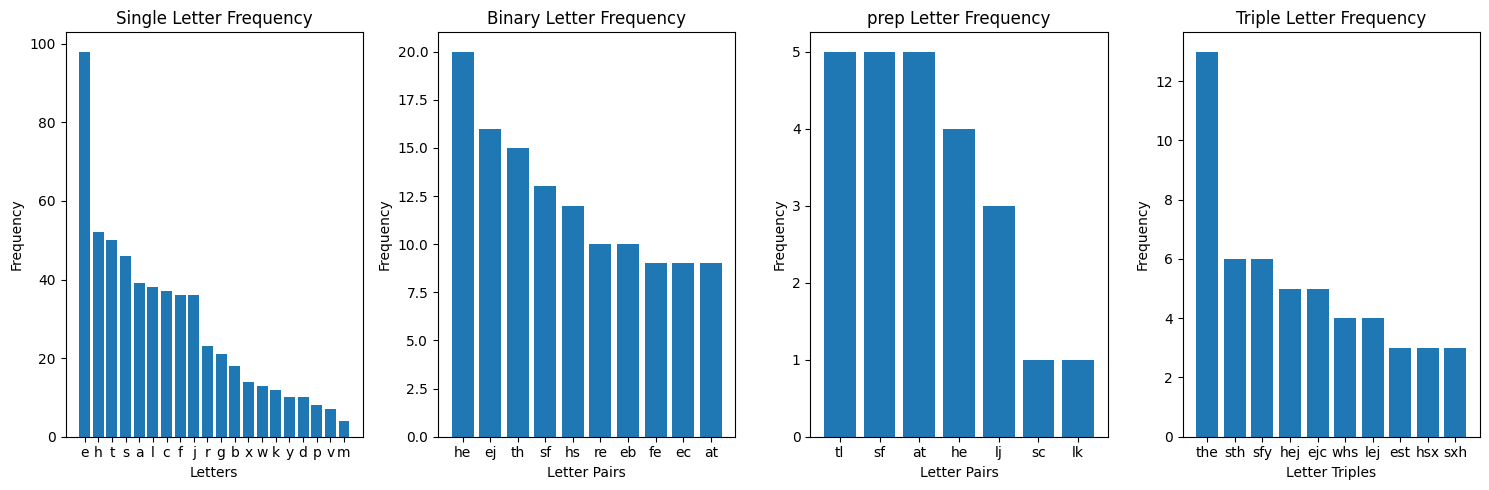

最终解密结果：
hhsreac klyy wac flt mflwf tl hade esthej wske lj xhsrbjef,
whsxh gav hahhef tl the glct hlfect helhre; esthej jeratsdec
lj feaj kjsefbc, whsxh sc xejtasfrv glje efecear. he rsdeb
arlfe sf hsc hlece sf cadsrre jlw, whsthej flfe hefetjateb.
a csfyre blgectsx cekksxeb tl cejde hsg. he pjeamkacteb afb
bsfeb at the xrep, at hlejc gathegatsxarrv ksaeb, sf the cage
jllg, at the cage tapre, fedej tamsfy hsc gearc wsth lthej
gegpejc, gexh recc pjsfysfy a yeect wsth hsg; afb weft hlge
at eaaxtrv gsbfsyht, lfrv tl jetsje at lfxe tl peb. he fedej
eceb the xlcv xhagpejc whsxh the jekljg hjldsbec klj stc
kadlejeb gegpejc. he hacceb tef hlejc let lk the tweftv-klej
sf cadsrre jlw. esthej sf creehsfy lj tamsfy hsc tlsret


In [57]:
if __name__ == '__main__':
    english_single = 'etaoinshrdlcumwfgypbvkjxqz'
    english_binary=''
    with open('sample.txt','r') as f:
        ciphertext=f.read()
    # 分析密文频率
    freq = analyze_frequency(ciphertext)
    # 生成初始映射
    mapping = generate_initial_mapping(freq)
    
    # 交互式调整映射
    final_mapping = interactive_adjustment(ciphertext,mapping)
    # 输出最终解密结果
    print("最终解密结果：")
    print(decrypt(ciphertext, final_mapping))